<a href="https://colab.research.google.com/github/abyssyli/Summer2025/blob/main/koffi612.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using PINNS to solve the Waive Equation (1D)**

Consider the one-dimensional wave equation:

$$
\frac{\partial^2 u(x, t)}{\partial t^2} = c^2 \frac{\partial^2 u(x, t)}{\partial x^2}, \quad x \in [0, 1],\ t \in [0, T]
$$

Where:

$ u(x, t) $ is the displacement (amplitude) of the wave at position $ x $ and time$ t$;

$ c $ is the wave speed (e.g., $c = 1.0 $);

The initial displacement is $ u(x, 0) = f(x) $, e.g., $f(x) = \sin(\pi x) $;

The initial velocity is $ \frac{\partial u}{\partial t}(x, 0) = g(x) $, e.g., $ g(x) = 0 $;

The boundary condition is $ u(0, t) = u(1, t) = 0 $.

---

The Basic Workflow of Using PINNs to Solve the 1D Wave Equation is:

1. Define a neural network with inputs $x, t$, and output $u(x, t)$.
2. Construct a loss function consisting of four components:

   (1) Initial displacement loss: $\mathcal{L}_{IC}$

   (2) Initial velocity loss: $\mathcal{L}_{IV}$

   (3) Boundary condition loss: $\mathcal{L}_{BC}$

   (4) PDE physics-informed loss  
     (based on automatic differentiation of $\frac{\partial^2 u}{\partial t^2}$ and $\frac{\partial^2 u}{\partial x^2}$):  
     $\mathcal{L}_{PDE}$

3. Train the neural network to minimize the total loss.

The details are listed in the following parts:


**Part 1. Set seeds**

The random seed is set to ensure reproducible results (the initialization parameters and training points are the same for each run)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)


**Part 2. Define the Neural Network**

Here, we define a three-layer neural network to approximate the solution of the wave equation.

The input to the network is a 2D point $(x, t)$, where $x$ is the spatial coordinate and $t$ is time.

The output is a single scalar value $u(x, t)$, representing the predicted solution at that point.

The output $u(x, t)$ represents the displacement (or amplitude) of the wave at a specific position $x$ and time $t$ in the system. *Physically*, this function describes how a wave propagates through space over time.

---

The network uses **Tanh** as the activation function, which is well-suited for approximating smooth physical solutions and maintaining numerical stability.

This neural network learns a function $u(x, t)$ that approximately satisfies:

the PDE residual $\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$,

the initial conditions,

and the Dirichlet boundary conditions.

---

#### Forward Pass of the PINN Model

The `forward()` method defines how the model processes input. It is called automatically when we run `model(x, t)`.

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))


**Part 3. Initialize the Network and Optimizer**

We initialize the neural network model (`PINN`) and the optimizer used for training.

Here, we also define the physical parameter $c = 1.0$, which represents the **wave speed** in the wave equation:

$\displaystyle \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$

This constant $c$ controls how fast the wave propagates through the domain.

Here a larger $c$ means the wave travels faster, while a smaller $c$ means slower wave propagation.

In this implementation, we use the Adam optimizer with a learning rate of $1 \times 10^{-3}$ to train the network.


In [3]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
c = 1.0  # wave speed

**Part 4. Sampling Training Points**

The data PINNs needs can be divided into three categories:

**1. PDE collocation points**

These points enforce the network to satisfy the differential equation.  
We have $N_f = 1000$ pieces of $f(x_f, t_f)$.

---

**Question**: How do these points 'force' the network to satisfy our PDE?

---

**Firstly**, recall that for traditional numerical methods to solve PDEs (like finite difference or finite element), the PDE is satisfied approximately on a discretized grid using difference formulas.  
For example, for the 1D **wave equation**:

$$
\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}
$$

we might write an approximation like:

$$
\frac{u(x, t + \Delta t) - 2u(x, t) + u(x, t - \Delta t)}{(\Delta t)^2}
\approx c^2 \cdot \frac{u(x + \Delta x, t) - 2u(x, t) + u(x - \Delta x, t)}{(\Delta x)^2}
$$

This approach requires a mesh and discretization of both time and space.

---

**However**, for PINNs, we represent the solution $u(x, t)$ as a neural network.  
Instead of discretizing the PDE, we train the network to minimize the **PDE residual** at a set of randomly sampled collocation points $(x_f, t_f)$:

$$
\left| \frac{\partial^2 u}{\partial t^2}(x_f, t_f) - c^2 \frac{\partial^2 u}{\partial x^2}(x_f, t_f) \right|^2 \to \min
$$

To this end, we want to implement this in code, and key idea is to use **automatic differentiation** (`autograd`) to compute the derivatives.

Here `u = model(x_f, t_f)` corresponds to the predicted $u(x, t)$.  
`u_t = torch.autograd.grad(u, t_f, ...)` corresponds to $\frac{\partial u}{\partial t}$.  
`u_x = torch.autograd.grad(u, x_f, ...)` corresponds to $\frac{\partial u}{\partial x}$.  
`u_xx = torch.autograd.grad(u_x, x_f, ...)` corresponds to $\frac{\partial^2 u}{\partial x^2}$.

Then the PDE loss is computed as:  
`python loss_f = torch.mean((u_tt - c**2 * u_xx) ** 2)`

This corresponds to the residual:

$$
\mathcal{L}_{\text{PDE}} = \frac{1}{N_f} \sum_{i=1}^{N_f}
\left( \frac{\partial^2 u}{\partial t^2}(x_i, t_i) - c^2 \frac{\partial^2 u}{\partial x^2}(x_i, t_i) \right)^2
$$

This penalizes the network if it does not satisfy the wave PDE at those points.

Hence, to use PINNs to solve the PDE, we do not provide target outputs $u(x, t)$.  
Instead, we train it to **minimize the PDE residual** at the sampled collocation points.

If the residual is not close to zero, the loss is high, and the network updates its parameters to reduce this error.  
This process forces the network to approximate a function that satisfies the PDE.




---

**2. Initial condition points $N_i$**

We define two types of initial conditions at time $t_i = 0$:

- $u(x, 0) = \sin(\pi x)$ is the **initial displacement**;
- $\frac{\partial u}{\partial t}(x, 0) = 0$ is the **initial velocity**.

These conditions specify both the shape and motion of the wave at the initial time.  
We sample $x_i$ uniformly in the domain $[0, 1]$ and fix $t_i = 0$.

The network learns to match:

- $model(x_i, t_i) \approx u_i$
- $\frac{\partial model(x_i, t_i)}{\partial t} \approx 0$

---

**3. Boundary condition points $N_b$**

We apply Dirichlet boundary conditions on both spatial ends of the domain:

- $x = 0$ is the left boundary;
- $x = 1$ is the right boundary;
- $t_b$ is sampled over the time interval $[0, 1]$.

The boundary condition is:

$$
u(0, t) = 0, \quad u(1, t) = 0
$$

The network must output zero at these boundary points for all time.


In [7]:
# Number of training points
N_f, N_i, N_b = 1000, 100, 100

# PDE collocation points sampled randomly from the interior of the domain (x ∈ [0,1], t ∈ [0,1])
x_f = torch.rand(N_f, 1)     # random spatial points for PDE residual
t_f = torch.rand(N_f, 1)     # random temporal points for PDE residual

# Initial condition points sampled at t = 0
x_i = torch.rand(N_i, 1)         # random spatial positions at initial time
t_i = torch.zeros_like(x_i)      # all time values set to t = 0
t_i.requires_grad = True     # allow gradient for ∂u/∂t at t = 0
u_i = torch.sin(np.pi * x_i)     # true initial displacement: u(x, 0) = sin(pi * x)
u_t_i = torch.zeros_like(x_i)    # true initial velocity: ∂u/∂t(x, 0) = 0

# Boundary condition points sampled at x = 0 and x = 1
t_b = torch.rand(N_b, 1)       # random time values for boundary condition
x_b0 = torch.zeros(N_b, 1)     # x = 0 boundary points
x_b1 = torch.ones(N_b, 1)      # x = 1 boundary points

### Part 5. Define PDE loss

The `loss_fn()` function defines the total loss used to train the PINNs.  
The total loss consists of three parts: the PDE residual term, the initial condition term, and the boundary condition term.

---

**Firstly**, it enables autograd tracking by setting `requires_grad=True` for `x_f` and `t_f`,  
which allows the model to compute derivatives of the network output $u(x, t)$ with respect to both space and time.

The neural network **then** predicts $u(x, t)$ at the collocation points $(x_f, t_f)$,  
which are randomly sampled from the interior of the domain.

Using `torch.autograd.grad`, the function calculates the necessary partial derivatives:  
$\frac{\partial u}{\partial x}$, $\frac{\partial^2 u}{\partial x^2}$, and $\frac{\partial^2 u}{\partial t^2}$.

These derivatives are used to construct the PDE residual.

---

The total loss consists of three components:

- **PDE loss:**
  $$
  \left\| \frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} \right\|^2
  $$

- **Initial loss:**  
  $$
  \left\| u(x, 0) - \sin(\pi x) \right\|^2 + \left\| \frac{\partial u}{\partial t}(x, 0) \right\|^2
  $$

- **Boundary loss:**  
  $$
  \left\| u(0, t) \right\|^2 + \left\| u(1, t) \right\|^2
  $$

---

**Question**: Why the initial loss function become an 'addition' like this?

That's because since the wave equation involves a second-order time derivative, the initial condition must include both displacement $u(x, 0)$ and velocity $\frac{\partial u}{\partial t}(x, 0)$.

---

We use `torch.autograd.grad()` to automatically compute first- and second-order derivatives.

The term `loss_f` represents the mean squared error of the residual  
$\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2}$,  
forcing the network to satisfy the wave equation across the domain.

The term `loss_i` enforces both the initial displacement and initial velocity conditions at $t = 0$:

- $u(x, 0) = \sin(\pi x)$  
- $\frac{\partial u}{\partial t}(x, 0) = 0$

The term `loss_b` handles the boundary conditions at $x = 0$ and $x = 1$,  
where the solution must always be zero:  
$u(0, t) = u(1, t) = 0$.

---

**Finally**, the function returns the sum of the three loss components as the total objective.  
This guides the network to learn a solution that satisfies the governing PDE,  
as well as the associated initial and boundary conditions.


In [8]:
# Define total loss: PDE residual + initial displacement + initial velocity + boundary condition
def loss_fn():
    # Enable gradient tracking for x_f and t_f to compute derivatives
    x_f.requires_grad = True
    t_f.requires_grad = True

    # Predict u(x,t) at collocation points for PDE
    u = model(x_f, t_f)

    # Compute second-order time derivative ∂²u/∂t²
    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t_f, torch.ones_like(u_t), create_graph=True)[0]

    # Compute second-order spatial derivative ∂²u/∂x²
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual loss: enforce ∂²u/∂t² = c² ∂²u/∂x²
    loss_f = torch.mean((u_tt - c**2 * u_xx)**2)

    # Initial displacement loss: enforce u(x,0) = sin(πx)
    loss_i = torch.mean((model(x_i, t_i) - u_i)**2)

    # Initial velocity loss: enforce ∂u/∂t(x,0) = 0
    u_t_pred = torch.autograd.grad(model(x_i, t_i), t_i, torch.ones_like(u_i), create_graph=True)[0]
    loss_it = torch.mean((u_t_pred - u_t_i)**2)

    # Boundary condition loss: enforce u(0,t) = u(1,t) = 0
    loss_b = torch.mean(model(x_b0, t_b)**2) + torch.mean(model(x_b1, t_b)**2)

    # Total loss: sum of all individual losses
    return loss_f + loss_i + loss_it + loss_b

**Part 6. Training Loop**

In each training iteration, we compute the total loss `total`.

We Use `.backward()` to perform backpropagation and `optimizer.step()` to update the network parameters.

In [9]:
for epoch in range(2000):
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.5f}")

Epoch 0: loss = 0.72914
Epoch 200: loss = 0.26372
Epoch 400: loss = 0.08628
Epoch 600: loss = 0.02359
Epoch 800: loss = 0.00455
Epoch 1000: loss = 0.00213
Epoch 1200: loss = 0.00129
Epoch 1400: loss = 0.00094
Epoch 1600: loss = 0.00085
Epoch 1800: loss = 0.00062


**Part 7. Construct a 2D $(x,t)$ Grid for Visualization of $u(x,t)$**

To evaluate and visualize the model's prediction over the entire domain, we create a 2D grid of size $100 \times 100$ using `torch.linspace()`.

To be more specific,  
$x_{\text{test}}$ and $t_{\text{test}}$ are linearly spaced points between $0$ and $1$, each reshaped to column vectors of shape $[100, 1]$.

`torch.meshgrid()` is used to create the full 2D grid $(X, T)$ where each point represents a unique $(x, t)$ pair.

$X$ and $T$ are flattened into $x_{\text{flat}}$ and $t_{\text{flat}}$, which are passed to the trained model for prediction.

This grid allows us to generate the full solution $u(x, t)$ and visualize the model’s output over space and time.

---

The **analytical (true) solution** of the wave equation is:  
$$ u_{\text{true}}(x, t) = \cos(\pi t) \cdot \sin(\pi x) $$

Both predicted and true values are reshaped into $100 \times 100$ grids to match the original mesh.

---

The **relative $L^2$ error** is computed as:  
$$
\text{Relative Error} = \frac{\| u_{\text{pred}} - u_{\text{true}} \|_2}{\| u_{\text{true}} \|_2}
$$

A small relative error (e.g., less than $10^{-2}$) indicates that the neural network has successfully learned an accurate approximation of the wave equation solution.


In [10]:
# Generate grid prediction over the (x, t) domain
x_test = torch.linspace(0, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")
x_flat = X.reshape(-1, 1)  # shape: (10000, 1)
t_flat = T.reshape(-1, 1)  # shape: (10000, 1)

# Evaluate model prediction and analytical solution
with torch.no_grad():
    u_pred = model(x_flat, t_flat).reshape(100, 100)
    u_true = torch.cos(np.pi * t_flat) * torch.sin(np.pi * x_flat)  # true wave solution
    u_true = u_true.reshape(100, 100)
    rel_error = torch.norm(u_pred - u_true) / torch.norm(u_true)
    print(f"\nRelative L2 error: {rel_error:.2e}")


Relative L2 error: 2.57e-02


**Part 8. Visualization of Results**

1. **PINN Prediction** ($u_{\text{pred}}$)

This is a contour heatmap of the predicted solution $u_{\text{pred}}(x, t)$ generated by the neural network over the space-time grid.

It visualizes how the model captures the wave propagation over space and time.

---

2. **Analytical Solution** ($u_{\text{true}}$)

This is the ground-truth solution computed from the exact formula for the 1D wave equation:

$$
u_{\text{true}}(x, t) = \cos(\pi t) \cdot \sin(\pi x)
$$

It serves as a reference to compare the accuracy of the predicted result.

---

3. **PDE Residual Histogram**

We compute the residual of the wave equation at the collocation points:

$$
\text{Residual} = \frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2}
$$

The histogram shows the distribution of residuals. Ideally, all residuals should be close to 0.

A sharp peak near 0 indicates that the predicted $u(x, t)$ approximately satisfies the wave equation.

---

All plots are placed side by side using `plt.subplot(1, 3, *)`, and `plt.tight_layout()` is used for better spacing.


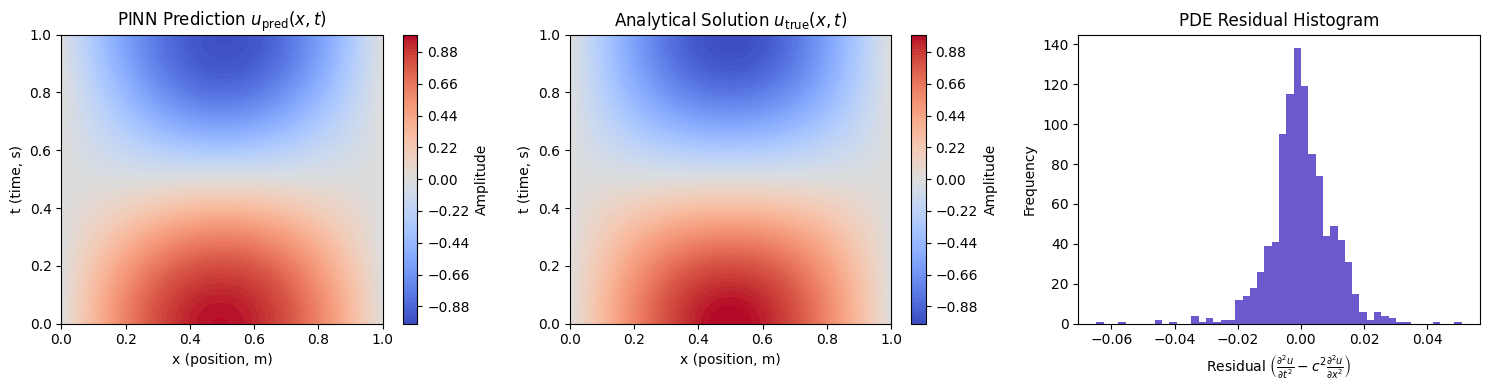

In [11]:
# Plot results for the wave equation

plt.figure(figsize=(15, 4))

# 1. PINN Prediction: u_pred(x, t)
plt.subplot(1, 3, 1)
plt.contourf(X.numpy(), T.numpy(), u_pred.numpy(), 100, cmap='coolwarm')
plt.title("PINN Prediction $u_{\\text{pred}}(x, t)$")
plt.xlabel("x (position, m)")
plt.ylabel("t (time, s)")
plt.colorbar(label="Amplitude")

# 2. Analytical Solution: u_true(x, t)
plt.subplot(1, 3, 2)
plt.contourf(X.numpy(), T.numpy(), u_true.numpy(), 100, cmap='coolwarm')
plt.title("Analytical Solution $u_{\\text{true}}(x, t)$")
plt.xlabel("x (position, m)")
plt.ylabel("t (time, s)")
plt.colorbar(label="Amplitude")

# 3. Residual Histogram: ∂²u/∂t² − c² ∂²u/∂x²
x_f.requires_grad = True
t_f.requires_grad = True
u = model(x_f, t_f)
u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
u_tt = torch.autograd.grad(u_t, t_f, torch.ones_like(u_t), create_graph=True)[0]
u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]
residual = (u_tt - c**2 * u_xx).detach().numpy()

plt.subplot(1, 3, 3)
plt.hist(residual, bins=50, color='slateblue')
plt.title("PDE Residual Histogram")
plt.xlabel("Residual $\\left( \\frac{\\partial^2 u}{\\partial t^2} - c^2 \\frac{\\partial^2 u}{\\partial x^2} \\right)$")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Finally, we plot the Training Loss Curves:

In [12]:
# Lists to store loss components
loss_f_list = []
loss_i_list = []
loss_it_list = []
loss_b_list = []

# Modified training loop
for epoch in range(2000):
    optimizer.zero_grad()
    x_f.requires_grad = True
    t_f.requires_grad = True

    u = model(x_f, t_f)
    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t_f, torch.ones_like(u_t), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]
    loss_f = torch.mean((u_tt - c**2 * u_xx)**2)

    u_pred_i = model(x_i, t_i)
    loss_i = torch.mean((u_pred_i - u_i)**2)

    u_t_pred = torch.autograd.grad(u_pred_i, t_i, torch.ones_like(u_i), create_graph=True)[0]
    loss_it = torch.mean((u_t_pred - u_t_i)**2)

    loss_b = torch.mean(model(x_b0, t_b)**2) + torch.mean(model(x_b1, t_b)**2)

    total_loss = loss_f + loss_i + loss_it + loss_b
    total_loss.backward()
    optimizer.step()

    # Save losses
    loss_f_list.append(loss_f.item())
    loss_i_list.append(loss_i.item() + loss_it.item())  # total initial condition loss
    loss_b_list.append(loss_b.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss.item():.5e}")


Epoch 0: Loss = 5.24813e-04
Epoch 200: Loss = 4.49359e-04
Epoch 400: Loss = 3.88006e-04
Epoch 600: Loss = 3.37231e-04
Epoch 800: Loss = 3.55983e-04
Epoch 1000: Loss = 2.55930e-04
Epoch 1200: Loss = 2.24079e-04
Epoch 1400: Loss = 1.96534e-04
Epoch 1600: Loss = 1.73011e-04
Epoch 1800: Loss = 1.52153e-04


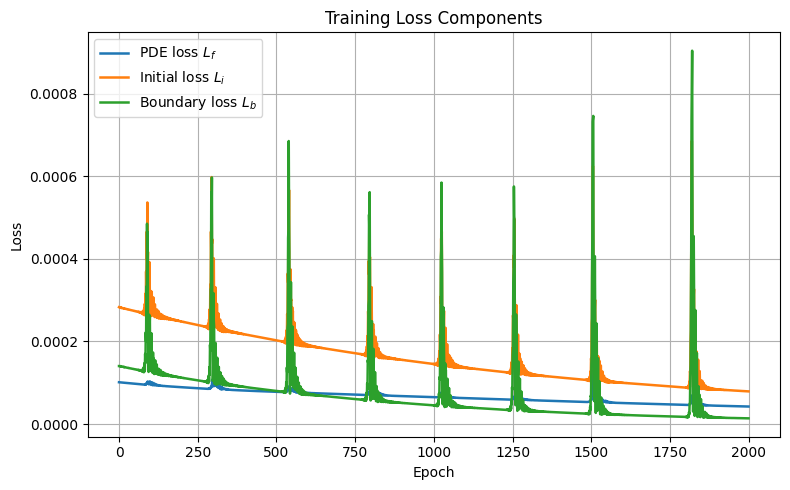

In [13]:
# Plot training loss curves
plt.figure(figsize=(8, 5))
plt.plot(loss_f_list, label="PDE loss $L_f$", linewidth=1.8)
plt.plot(loss_i_list, label="Initial loss $L_i$", linewidth=1.8)
plt.plot(loss_b_list, label="Boundary loss $L_b$", linewidth=1.8)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Components")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


That's the end!
I am going to catch the flight now!

Is that the so-called wave visualization you want? If not then sorry about that! I can fixt it later.

I will continue the next update at around next Wednesday after I rent a VPN.

Bye bye bye ~